# NIR Spectral Analysis with AS7263 
A clean, step-by-step notebook to:
1. Load & visualize spectral data
2. Preprocess inputs & encode outputs
3. Build & visualize Conv1D → MLP multi-output model
4. Train & plot learning curves
5. Evaluate & save final model

**Dataset include:**
610nm	680nm	730nm	760nm	810nm	860nm	fruit	brix	ripeness	moisture	grade	defect	fungus

**Input include:**
- 6-dimensional Vector NIR Spectral: [610nm, 680nm, 730nm, 760nm, 810nm, 860nm]
- fruit type
- ripeness

**Outputs include:**
- °Brix (regression)
- Ripeness (regression)
- Moisture content (regression)
- Grade (A/B/C classification)
- Internal defect (Y/N)
- Disease or fungal infection (Y/N)

In [1]:
!pip install -q tensorflow
!pip install scikit-learn
!pip install seaborn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense
from tensorflow.keras.utils import plot_model



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Load Dataset & Initial Visualization

In [2]:
# Đường dẫn file CSV của bạn
csv_path = "data_nir/nir_spectral_dataset_augmented_v5.csv"  # 🔁 thay nếu cần

# Đọc dữ liệu
df = pd.read_csv(csv_path)

# Hiển thị bảng dữ liệu
print("📊 Dữ liệu từ file CSV:")
df.head(200)  # Hiển thị 20 dòng đầu tiên


📊 Dữ liệu từ file CSV:


,610nm,680nm,730nm,760nm,810nm,860nm,fruit,brix,ripeness,moisture,defect,fungus,grade
0,0.532274,0.570942,0.606437,0.519099,0.605931,0.560514,banana,19.384176,9.471140,73.921307,1,0,B
1,0.557323,0.687065,0.694000,0.654424,0.741349,0.728600,banana,20.384176,8.407675,77.845837,0,0,A
2,0.537385,0.621036,0.596457,0.569814,0.606455,0.575427,banana,17.385288,7.137076,77.684838,0,1,C
3,0.406939,0.449086,0.417753,0.448803,0.413857,0.383700,apple,10.487825,6.925489,84.485849,1,1,C
4,0.523930,0.611115,0.510181,0.525841,0.559322,0.550366,mango,14.490006,6.020631,80.579782,1,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.490528,0.620518,0.473375,0.462102,0.561690,0.568692,mango,13.784146,6.964758,79.200920,0,1,C
196,0.455852,0.532842,0.465013,0.515664,0.519704,0.513335,apple,11.261516,5.978956,87.938834,0,0,C
197,0.521117,0.589505,0.506868,0.521940,0.537895,0.578945,mango,13.864314,5.900932,81.556487,1,0,C
198,0.442887,0.431006,0.414621,0.438509,0.404770,0.390990,apple,11.383385,7.073121,83.345365,0,1,C


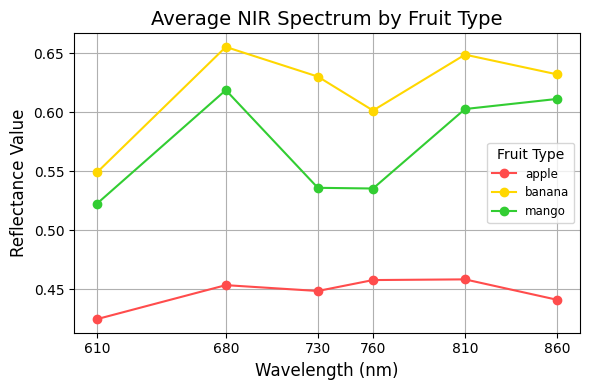

<Figure size 640x480 with 0 Axes>

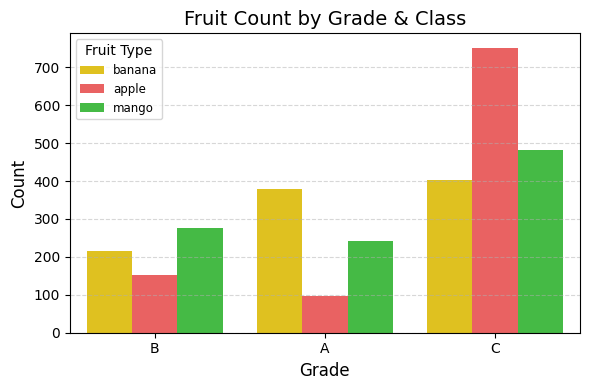

<Figure size 640x480 with 0 Axes>

In [3]:
# Các cột phổ
wavelengths = ['610nm', '680nm', '730nm', '760nm', '810nm', '860nm']
wavelength_vals = [610, 680, 730, 760, 810, 860]

# Tính trung bình cường độ tại mỗi bước sóng
mean_vals = df[wavelengths].mean()

# Tính trung bình phổ theo loại trái cây
avg_spectra = df.groupby('fruit')[wavelengths].mean()

custom_palette = {
    'apple': '#FF4C4C',    # đỏ
    'banana': '#FFD700',   # vàng
    'mango': '#32CD32'     # cam
}

# Vẽ biểu đồ đường phổ trung bình theo từng loại trái cây
plt.figure(figsize=(6, 4))
for fruit, row in avg_spectra.iterrows():
    plt.plot(wavelength_vals, row.values, label=fruit, marker='o', color=custom_palette.get(fruit,'gray'))

plt.title("Average NIR Spectrum by Fruit Type", fontsize=14)
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Reflectance Value", fontsize=12)
plt.xticks(wavelength_vals)
plt.grid(True)
plt.legend(title="Fruit Type", fontsize=8.5, title_fontsize=10)
plt.tight_layout()
plt.show()

plt.savefig('data_nir/avg_spectrum_by_fruit.png', dpi=300)
plt.show()


# Vẽ biểu đồ đếm số lượng theo fruit và grade
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='grade', hue='fruit', palette=custom_palette)

plt.title("Fruit Count by Grade & Class", fontsize=14)
plt.xlabel("Grade", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Fruit Type", fontsize=8.5, title_fontsize=10)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.savefig('data_nir/fruit_count_by_grade.png', dpi=300)
plt.show()


## 2. Preprocessing

In [4]:
# 1. Đặc trưng phổ NIR (6 bước sóng)
wavelengths = ['610nm', '680nm', '730nm', '760nm', '810nm', '860nm']
# 2. One-hot encode cột 'fruit'
df = pd.get_dummies(df, columns=['fruit'])  # → fruit_apple, fruit_mango, fruit_banana (tuỳ dataset)
fruit_features = [col for col in df.columns if col.startswith("fruit_")]

# 3. Tạo đầu vào X: gồm phổ + one-hot fruit + ripeness (CV output)
X_raw = df[wavelengths + fruit_features + ['ripeness']].values  # → (6 + n_fruit + 1) đặc trưng

# 4. Đầu ra liên tục (regression): °Brix, độ chín, độ ẩm
y_reg = df[['brix', 'ripeness', 'moisture']].values

# 5. Đầu ra phân loại: grade (A/B/C), defect (Y/N), fungus (Y/N)
y_cat = df[['grade', 'defect', 'fungus']].copy()

# 6. One-hot encode 'grade'
enc = OneHotEncoder(sparse_output=False)
y_grade = enc.fit_transform(y_cat[['grade']])  # → (samples, 3)

# 7. Encode nhị phân cho 'defect' và 'fungus'
y_defect = y_cat['defect'].astype(int).values  # → 0 hoặc 1
y_fungus = y_cat['fungus'].astype(int).values

# 8. Scale đầu vào và reshape (samples, features, 1) cho Conv1D
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_cnn = X_scaled.reshape(-1, X_scaled.shape[1], 1)  # → (samples, số đặc trưng, 1)

# 9. Train-test split
X_train, X_test, y_reg_train, y_reg_test, y_grade_train, y_grade_test, y_def_train, y_def_test, y_fun_train, y_fun_test = train_test_split(
    X_cnn, y_reg, y_grade, y_defect, y_fungus, test_size=0.2, random_state=42
)

# Kiểm tra kích thước
print('Data shapes:')
print('X_train:', X_train.shape)
print('y_reg_train:', y_reg_train.shape)
print('y_grade_train:', y_grade_train.shape)

Data shapes:
X_train: (2400, 10, 1)
y_reg_train: (2400, 3)
y_grade_train: (2400, 3)


## 3. Build Model

In [5]:
# Đầu vào: 10 đặc trưng (6 bước sóng + n loại quả + 1 ripeness)
inp = Input((10, 1))  # ← đã chỉnh từ (9,1) thành (10,1)

# 🧠 Tầng Conv1D: học mối liên hệ giữa các đặc trưng
x = Conv1D(16, kernel_size=2, activation='relu')(inp)  # (None, 9, 16)

# 📉 Làm phẳng
x = Flatten()(x)  # (None, 144)

# 🔗 MLP
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

# 🎯 Đầu ra hồi quy: °Brix, ripeness, moisture
reg_out = Dense(3, name='regression')(x)

# 🎯 Đầu ra phân loại đa lớp: grade A/B/C
grade_out = Dense(3, activation='softmax', name='grade')(x)

# 🎯 Đầu ra nhị phân: defect (Y/N) và fungus (Y/N)
def_out = Dense(1, activation='sigmoid', name='defect')(x)
fun_out = Dense(1, activation='sigmoid', name='fungus')(x)

# 🔗 Kết hợp các nhánh output
model = Model(inputs=inp, outputs=[reg_out, grade_out, def_out, fun_out])

## 4. Compile Model

In [6]:
# ⚙️ Compile
model.compile(
    optimizer='adam',
    loss={
        'regression': 'mse',
        'grade': 'categorical_crossentropy',
        'defect': 'binary_crossentropy',
        'fungus': 'binary_crossentropy'
    },
    metrics={
        'regression': 'mae',
        'grade': 'accuracy',
        'defect': 'accuracy',
        'fungus': 'accuracy'
    }
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 9, 16)     │         48 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 144)       │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,640 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 3)         │         51 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grade (Dense)       │ (None, 3)         │         51 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defect (Dense)      │ (None, 1)         │         17 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fungus (Dense)      │ (None, 1)         │         17 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,352 (20.91 KB)

 Trainable params: 5,352 (20.91 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train & Plot Learning Curves

Epoch 1/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - defect_accuracy: 0.6375 - defect_loss: 0.6486 - fungus_accuracy: 0.5589 - fungus_loss: 1.4158 - grade_accuracy: 0.2219 - grade_loss: 1.5552 - loss: 1823.3376 - regression_loss: 1819.7181 - regression_mae: 29.7314 - val_defect_accuracy: 0.6617 - val_defect_loss: 0.6373 - val_fungus_accuracy: 0.6133 - val_fungus_loss: 0.7474 - val_grade_accuracy: 0.4883 - val_grade_loss: 1.3931 - val_loss: 70.5320 - val_regression_loss: 67.6251 - val_regression_mae: 5.6150
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - defect_accuracy: 0.6738 - defect_loss: 0.6242 - fungus_accuracy: 0.4708 - fungus_loss: 0.7459 - grade_accuracy: 0.3185 - grade_loss: 1.4193 - loss: 51.9575 - regression_loss: 49.1680 - regression_mae: 4.7755 - val_defect_accuracy: 0.6533 - val_defect_loss: 0.6381 - val_fungus_accuracy: 0.3233 - val_fungus_loss: 0.7419 - val_grade_accuracy: 0.5300 - val_grade_loss: 1.3240 - val_loss: 23.4739 - val_regression_loss: 20.6726 - val_re

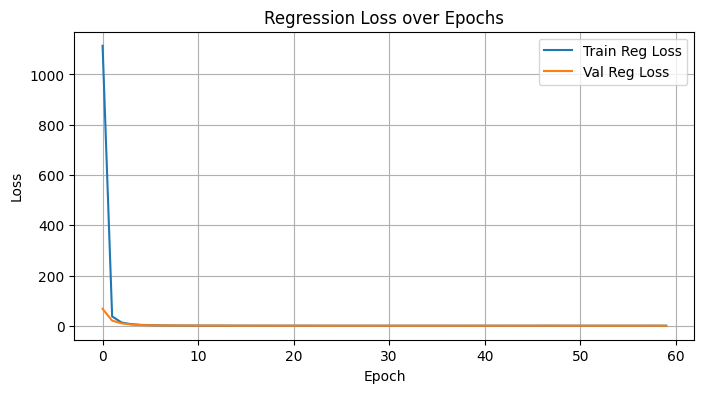

In [7]:
# Huấn luyện mô hình
history = model.fit(
    X_train,
    [y_reg_train, y_grade_train, y_def_train, y_fun_train],
    validation_data=(X_test, [y_reg_test, y_grade_test, y_def_test, y_fun_test]),
    epochs=60,
    batch_size=16
)

# Vẽ loss của nhánh regression
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['regression_loss'], label='Train Reg Loss')
plt.plot(history.history['val_regression_loss'], label='Val Reg Loss')
plt.title('Regression Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##6 test thủ công số liệu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
🎯 Inference Result for Manual Input
────────────────────────────────────────────
📌 Predicted Brix (°Bx):      19.91
📌 Predicted Ripeness:        9.49/10
📌 Predicted Moisture (%):    78.20

🏷️ Grade Prediction:          A → Confidence: 99.98%
⚠️ Internal Defect:           No → Confidence: 1.84%
🍄 Fungus Infection:          No → Confidence: 0.04%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


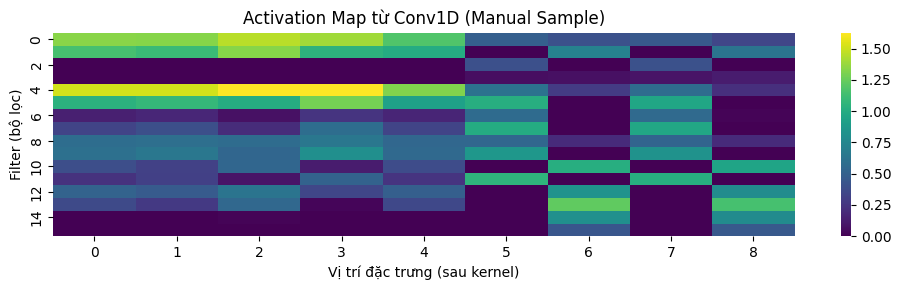

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


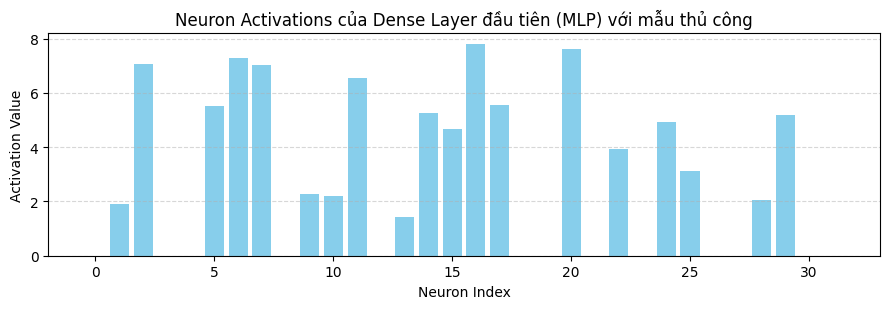

In [8]:

# 📥 Nhập thủ công: 6 vector NIR + 3 loại quả (banana) + 1 độ chín (CV output)
manual_input = np.array([[ 
    0.605125,  # 610nm
    0.745806,  # 680nm
    0.697865,  # 730nm
    0.693524,  # 760nm
    0.724187,  # 810nm
    0.727071,  # 860nm
    0,         # fruit_apple
    1,         # fruit_banana
    0,         # fruit_mango
    9.26      # ripeness score từ CV model
]])

# ✅ Scale dữ liệu đầu vào
manual_input_scaled = scaler.transform(manual_input)

# ✅ Reshape phù hợp input shape (1 sample, 10 features, 1 channel)
manual_input_scaled = manual_input_scaled.reshape((1, 10, 1))

# 🚀 Dự đoán từ model
pred_reg, pred_grade, pred_defect, pred_fungus = model.predict(manual_input_scaled)

# 🧾 In kết quả rõ ràng
grade_map = {0: 'A', 1: 'B', 2: 'C'}

print("🎯 Inference Result for Manual Input")
print("────────────────────────────────────────────")
print(f"📌 Predicted Brix (°Bx):      {pred_reg[0][0]:.2f}")
print(f"📌 Predicted Ripeness:        {pred_reg[0][1]:.2f}/10")
print(f"📌 Predicted Moisture (%):    {pred_reg[0][2]:.2f}")
print()
print(f"🏷️ Grade Prediction:          {grade_map[np.argmax(pred_grade[0])]} → Confidence: {np.max(pred_grade[0]):.2%}")
print(f"⚠️ Internal Defect:           {'Yes' if pred_defect[0][0] > 0.5 else 'No'} → Confidence: {pred_defect[0][0]:.2%}")
print(f"🍄 Fungus Infection:          {'Yes' if pred_fungus[0][0] > 0.5 else 'No'} → Confidence: {pred_fungus[0][0]:.2%}")




# ⚙️ Trích layer Conv1D đầu tiên
conv_layer = [layer for layer in model.layers if isinstance(layer, Conv1D)][0]
feature_extractor = Model(inputs=model.input, outputs=conv_layer.output)

# 🧪 Chọn sample để phân tích (có thể là sample thủ công hoặc từ X_test)
# Đây ta dùng lại manual_input_scaled
features = feature_extractor.predict(manual_input_scaled)

# 📊 Vẽ heatmap biểu diễn kích hoạt
plt.figure(figsize=(10, 3))
sns.heatmap(features[0].T, cmap='viridis', xticklabels=range(features.shape[1]))
plt.title("Activation Map từ Conv1D (Manual Sample)")
plt.xlabel("Vị trí đặc trưng (sau kernel)")
plt.ylabel("Filter (bộ lọc)")
plt.tight_layout()
plt.show()

# ⚙️ Trích layer Dense đầu tiên (sau CNN, thường là bước đầu MLP)
# Bạn có thể thay đổi tên nếu khác, hoặc in toàn bộ layer để kiểm tra
dense_layer = [layer for layer in model.layers if 'dense' in layer.name][0]

# 🧪 Tạo model phụ để trích đầu ra từ dense layer này
from tensorflow.keras.models import Model
mlp_feature_extractor = Model(inputs=model.input, outputs=dense_layer.output)

# 📤 Lấy đầu ra từ MLP với mẫu manual_input_scaled
mlp_features = mlp_feature_extractor.predict(manual_input_scaled)

# 📊 Vẽ biểu đồ thanh thể hiện giá trị kích hoạt của các neuron MLP
plt.figure(figsize=(9, 3.2))
plt.bar(range(mlp_features.shape[1]), mlp_features[0], color='skyblue')
plt.title("Neuron Activations của Dense Layer đầu tiên (MLP) với mẫu thủ công")
plt.xlabel("Neuron Index")
plt.ylabel("Activation Value")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Trích layer Dense đầu tiên (MLP)
dense_layer = [layer for layer in model.layers if 'dense' in layer.name][0]
mlp_feature_model = Model(inputs=model.input, outputs=dense_layer.output)

fruit_cols = [col for col in df.columns if col.startswith("fruit_")]
df['fruit_label'] = df[fruit_cols].idxmax(axis=1).str.replace("fruit_", "")


## 7. Evaluate & Save Model

In [9]:
model.evaluate(X_test, [y_reg_test, y_grade_test, y_def_test, y_fun_test])
model.save('nir_model_v3.h5')
print('Saved as nir_model_v3.h5')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - defect_accuracy: 0.7956 - defect_loss: 0.3749 - fungus_accuracy: 0.8430 - fungus_loss: 0.2993 - grade_accuracy: 0.8711 - grade_loss: 0.3084 - loss: 1.4527 - regression_loss: 0.4704 - regression_mae: 0.4336 


Saved as nir_model_v3.h5
